In [3]:
import os,gc,sys
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy
from glob import glob

import pickle
# import feather
%matplotlib inline

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from matplotlib.colors import ListedColormap

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from itertools import cycle

plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted",
        color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

In [4]:
#表示するrow,columns調整
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [25]:
#分析・集計に使うモジュールとライブラリ
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

#各種機械学習モデル
#LogisticRegression
from sklearn.linear_model import LogisticRegression
#Linear Support Vector Machine
from sklearn.svm import LinearSVC
#Support Vector Machine
from sklearn.svm import SVC
#決定木
from sklearn.tree import DecisionTreeClassifier
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
#k近傍方（k-neighbor）
from sklearn.neighbors import KNeighborsClassifier
#Logistic-regression
from sklearn.linear_model import LogisticRegression

#学習方法（GridSearchCV）
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#scikiti-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score

#スコアリング（f値）
from sklearn.metrics import f1_score

#lightgbm
import lightgbm as lgb

#XGBoost
import xgboost as xgb

# import pandas_profiling as pdp


In [6]:
from sklearn.datasets import load_iris
iris = load_iris()

In [11]:
data= iris.data
target = iris.target

In [13]:
print(data.shape)
print(target.shape)

(150, 4)
(150,)


In [14]:
# 目的変数を確認した結果、データが偏っているのでランダムにシャッフルした上で、トレーニング用データと検証用データに分割する
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, stratify=iris.target,random_state=10)

In [17]:
## チューニングするパラメータ
tuned_parameters = {'max_depth':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # 木の深さを1-10で
                    'max_leaf_nodes':  [2,4,6,8,10] # 最大終端ノード数を2,4,6,8,10で
                   }

# 上記で用意したパラメーターごとに交差検証を実施。最適な木の深さを確認する。
clf = GridSearchCV(DecisionTreeClassifier(random_state=0, splitter='best'), 
                   tuned_parameters, 
                   scoring="accuracy", 
                   cv=5, 
                   n_jobs=-1)

clf = clf.fit(X_train, y_train) # モデル作成!

print("Best Parameter: {}".format(clf.best_params_))
print("Best Parameterでの検証用データの精度: {:.2f}".format(clf.score(X_test, y_test)))
print("Best Parameterで交差検証した精度の平均（訓練データ）: {:.2f}".format(clf.best_score_))

Best Parameter: {'max_depth': 6, 'max_leaf_nodes': 10}
Best Parameterでの検証用データの精度: 1.00
Best Parameterで交差検証した精度の平均（訓練データ）: 0.95


In [21]:
from sklearn import tree

In [22]:
'''4.可視化
分析結果をファイルにして出力した後、そのファイルを読み込んで可視化します。
ターミナルで「pip install graphviz」を実行して、graphvizをインストールする必要があります。
'''

# パラメータ調整の結果、もっとも精度がよかった木の深さを採用 
clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6, random_state=0)
clf = clf.fit(X_train,y_train)

# tree.dotという名前で分析結果を出力
tree.export_graphviz(clf, out_file="tree.dot",
                         feature_names=iris.feature_names,
                         class_names=iris.target_names,
                         filled=True, rounded=True, impurity=False)


# tree.dotファイルを可視化
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


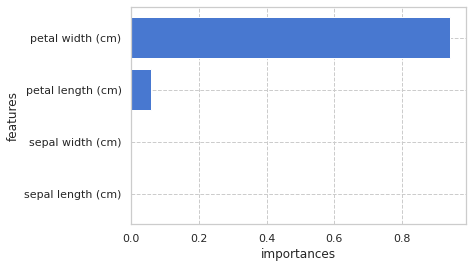

In [23]:
def plot_feature_importances(model):
    n_features = iris.data.shape[1] # 全説明変数
    plt.barh(range(n_features), model.feature_importances_, align='center') # 描画する際の枠組みを設定
    plt.yticks(np.arange(n_features), iris.feature_names) # 縦軸の設定
    plt.xlabel('importances') # 横軸の設定
    plt.ylabel('features') # 縦軸の設定
    plt.show()

# 実行
plot_feature_importances(clf)


### LightGBM, XGBoost

### BaseModel

"LightGBM", "XGBoost"をベースモデルとして用いた，メタモデリングという意味でのアンサンブルを取り上げる．

In [27]:
def lgb_analysis(X_train, X_test, y_train, y_test, n_folds=5):
    
    #Base analysis
    
    kf = KFold(n_splits=n_folds, random_state=1)
    y_preds_train = []
    y_preds_test = []
    
    for k, (train, test) in enumerate(kf.split(X_train, y_train)):
        gbm = lgb.LGBMClassifier(objective='multiclass',
                                 num_leaves=23,
                                 learning_rate=0.1,
                                 n_estimators=100)
        
        gbm.fit(X_train[test], y_train[test],
                eval_set=[(X_train[test], y_train[test])],
                eval_metric='multi_logloss',
                verbose=False,
                early_sttoping_rounds=10)
        
        y_pred_train = gbm.predict_proba_(X_train[test],
                                           num_iteration=gbm.best_iteration)
        y_pred_test =  gbm.predict_proba_(X_test,
                                           num_iteration=gbm.best_iteration)
        y_pred_k = np.argmax(y_preds_test, axis=1)
        accu= accuracy_score(y_test, y_pred_k)
        
        print(f'fold[{k:>3d}]: accuracy = {accu:>.4f}')
        
        y_preds_train.append(y_pred_train)
        y_preds_test.append(y_pred_test)
        
    return y_preds_train, y_preds_test

In [28]:
def xgb_analysis(X_train, X_test, y_train, y_test, n_folds=5):
    
    #Base analysis
    
    kf = KFold(n_splits=n_folds, random_state=1)
    y_preds_train = []
    y_preds_test = []
    
    for k, (train, test) in enumerate(kf.split(X_train, y_train)):
        xgbclf = xgb.XGBClassifier(objective='multi:softmax',
                                   max_depth=5,
                                   learning_rate=0.1,
                                   n_estimators=100)
        
        xgbclf.fit(X_train[test], y_train[test],
                   eval_set=[(X_train[test], y_train[test])],
                   eval_metric='mlogloss',
                   verbose=False,
                   early_sttoping_rounds=10)
        
        y_pred_train = xgbclf.predict_proba_(X_train[test],
                                           num_iteration=gbm.best_iteration)
        y_pred_test =  xgbclf.predict_proba_(X_test,
                                           num_iteration=gbm.best_iteration)
        y_pred_k = np.argmax(y_preds_test, axis=1)
        accu= accuracy_score(y_test, y_pred_k)
        
        print(f'fold[{k:>3d}]: accuracy = {accu:>.4f}')
        
        y_preds_train.append(y_pred_train)
        y_preds_test.append(y_pred_test)
        
    return y_preds_train, y_preds_test